## Explorative search, graph-based discovery of text documents

This notebook introduces Explorative Search. This is a document-word graph-based search technique that leverages NLP and Pagerank, to explore text collections and discover unexpected relations between them. At the end, you get a way to retrieve documents that contains a keyword, or that share words similar to documents with this keyword. 

### Introduction

Imagine you have a collection of text documents, and you want to retrieve those which are related to a keyword. A rule of thumb would be : type a keyword, get me all the documents that have this keyword in their text. 

To rank those results by "relevance", classical techniques, such as [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25), are based around Term Frequency (how much the keyword is present in the document) and Inverse Document Frequency (how rare and specific the keyword is). Documents where the keyword is frequent are ranked higher than those where it's not.

**This traditional technique works well if you know exactly what you are looking for. But if you don't, it falls appart.**  

This is especially the case when dealing with a large knowledge base, where you don't really know what's inside. Instead of looking up for a perticular document, you usually want to just explore the collection, discover interesting relations, or get a better undersanding of the knowledge base. For example, by searching for the keyword "yoghourt", you'd actually be interested in learning about "milk industry", "agricultural sector", "rural areas", and other stuff loosely related to yoghourt.

The technique I introduce here helps you discover a text-based knowledge base by leveraging a document-word graph representation of the document collection. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sknetwork.visualization import svg_bigraph
from IPython.display import SVG
from sknetwork.ranking import BiPageRank, top_k, PageRank

stop_words = ["I", "the", "he", "she", "it", "is", "of", "to", "in", "his", "her", "their", "its", "a", "out", "of", "on", "up", "with", "for", "at", "should", "not", "is", "as", "no", "and", "by", "be", "into", "from"]

### Data 

We will be working with a dataset of ABC news headlines (Austalian Broadcasting Corporation). Thanks to Rohit Kulkarni for [sharing this dataset on Kaggle](https://www.kaggle.com/therohk/million-headlines). There are more than a million headlines in this dataset. 

In [2]:
df = pd.read_csv("data/abcnews-date-text.csv")
df.drop_duplicates(subset=["headline_text"], ignore_index=True, inplace=True)
print(f"Number of documents: {df.shape[0]}")

Number of documents: 1155838


## Creating a graph out of text

A bag-of-word embedding is a vector representation of text, where each row is a document and each column is a word. In its simplest form, if a word is in a document, then there is a 1 in the cell. Otherwise, there is 0. 

For a corpus of text, this representation can be interpretated as a [bigraph](https://en.wikipedia.org/wiki/Bigraph) adjacency matrix. That is, the mathematical encoding of a graph, where documents are linked to each other through shared words. This is called a document-word graph.

Below, on the left, you have 30 random article headlines. On the right, they are connected to words. You can jump from an article to another by following their common words. 

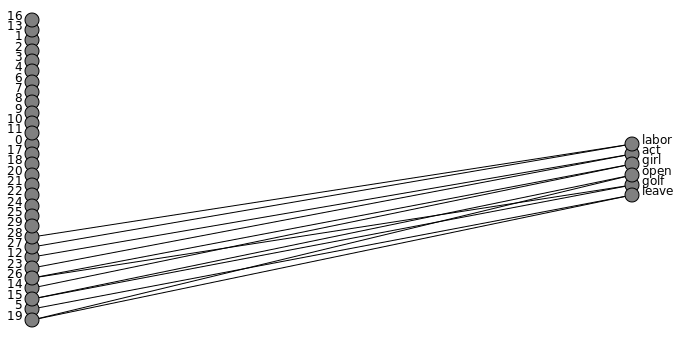

In [3]:
nb_sub_samples = 30
small_df = df.sample(nb_sub_samples, random_state=10)

# Note that min_df is 2 : we only consider words that are present in 2 documents
count_2 = CountVectorizer(min_df=2, binary=True, stop_words=stop_words)
small_adjacency = count_2.fit_transform(small_df["headline_text"])
reverse_vocab = {v: k for k, v in count_2.vocabulary_.items()}
names_col = [reverse_vocab[i] for i in range(len(reverse_vocab))]
names_row = list(range(nb_sub_samples))

image = svg_bigraph(small_adjacency, names_row=names_row, names_col=names_col, width=600)
SVG(image)

Let's now do this on the full dataset. Since it's so big, we won't be showing the graph. Note that this graph only needs to be computed once. 

In [4]:
%%time 

count = CountVectorizer(min_df=2, binary=True, stop_words=stop_words)
adjacency = count.fit_transform(df['headline_text'])
print("Shape of the full adjacency matrix:", adjacency.shape)
print("Number of non-zero elements:", adjacency.nnz)

Shape of the full adjacency matrix: (1155838, 62077)
Number of non-zero elements: 6471079
CPU times: user 9.37 s, sys: 155 ms, total: 9.53 s
Wall time: 9.53 s


## Using PageRank to search through documents

We are going to use a variant of PageRank algorithm on this adjacency matrix. 

### The PageRank algorithm

[PageRank](https://en.wikipedia.org/wiki/PageRank) is an algorithm developed by Google in the 2000s to find relevant websites based on their URL links. At the time, websites at the top of Google seach were those who were the most linked to, and by websites that were also the most linked to. This ranking of websites is made by averaging several random walks on the website-website graph. 

Intuitively, imagine robots starting on random webpages, that randomly click on any link they see. These robots keep a record on which websites they end up most often : those would be at the top of the search results. At the end, they create a ranking of all the websites. [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) theory guarantees that the PageRank algorithm converges towards a unique ranking of the websites. 

BiPageRank is the same idea, but applied to bigraphs. In our case, the algorithm will perform a random walk from an article, to a word, to another article, to a word, and so on. 

Computationally, this random walk is nothing more than matrix-vector multiplications, something we can easily parallelize and speed up. 

In [5]:
bpr = BiPageRank()

def disp_results(df, scores, k=10, col='headline_text'):
    for rank, (i, row) in enumerate(df.iloc[top_k(scores, k)].iterrows()):
        print(f"{rank+1}: (idx: {i}) {row[col]}")

In [6]:
scores = bpr.fit_transform(adjacency)

disp_results(df, scores)

1: (idx: 1077357) what did your 10 year old self think you would be 20 years later
2: (idx: 954323) nrn spring in nsw has kicked off well but rain needed in 10 days
3: (idx: 837662) manly sea eagles post 14 12 nrl win over south sydney rabbitohs
4: (idx: 837969) wests tigers post comfortable 42 12 nrl win over gold coast tit
5: (idx: 1119404) new hiv cases in wa hit 10 year low thanks to prep pill success
6: (idx: 1052899) afl scorecentre nmfc crows pies blues port wce gc cats dogs rich
7: (idx: 1090106) north qld town cut off record flood levels big wet heading west
8: (idx: 1101349) full time job rate hits new low as casual work takes over report
9: (idx: 924509) warriors score last gasp 20 16 win over sharks after frantic fi
10: (idx: 850178) south sydney rabbitohs post 40 18 nrl win over gold coast titan


### Personalized PageRank

The variant we will be using is called Personalized BiPageRank. Basically, instead of starting our random walk anywhere on the graph, we make it start on a specific node of the graph. To get search results relevant to a word, we will be starting our random walk on this word's node. 

In [7]:
%%time
scores = bpr.fit_transform(adjacency, seeds_col={count.vocabulary_["threat"]:1})

disp_results(df, scores)

1: (idx: 487215) tsunami threat overhyped
2: (idx: 976724) sandery death threat misunderstanding killa nickname
3: (idx: 194094) tunbridge dam leak threat eases
4: (idx: 435816) mccrae grassfire no longer a threat
5: (idx: 435817) mccrae residents face fire threat
6: (idx: 818197) patient blacklisting threat symptomatic of
7: (idx: 425455) wanilla fire threat eases
8: (idx: 957885) kinkuna homes threat of bushfire
9: (idx: 440708) octuplets grandmother faces foreclosure threat
10: (idx: 277854) pichi richi marathon under threat
CPU times: user 3.17 s, sys: 284 ms, total: 3.45 s
Wall time: 3.45 s


We can also do it by starting on an article's node. This acts as a recommendation of "similar articles". The article we look at is "more women urged to become councillors". It yields us articles about various urges over councillors.

In [8]:
scores = bpr.fit_transform(adjacency, seeds_row={100:1})

disp_results(df, scores)

1: (idx: 100) more women urged to become councillors
2: (idx: 181431) push on for more women councillors
3: (idx: 860260) councillors urged to back more wholistic way to
4: (idx: 107014) blokes chauvinism dudding potential councillors
5: (idx: 369155) new councillors urged to quickly grasp issues
6: (idx: 853565) councillors urged to back old castlemaine gaol
7: (idx: 647743) lake councillors urged to reject biodiversity offsets policy
8: (idx: 999085) perth councillors urged not to criticise lord mayor scaffidi
9: (idx: 43309) councillors urged to consider roles during
10: (idx: 446823) lake wooloweyah subdivision divides councillors


We can also start from several nodes, both articles and words, to perform complex searches. For example, let's look at articles similar to "more women urged to become councillors", but also to "police" and "fire". The third result is about a man charged (i.e. arrested by the *police*) after setting a *fire* in *councillors* office : very relevant to our bizarre search query. 

In [9]:
%%time
scores = bpr.fit_transform(adjacency, seeds_row={100:1}, seeds_col={count.vocabulary_["police"]:1, count.vocabulary_["fire"]:1})

disp_results(df, scores, 20)

1: (idx: 100) more women urged to become councillors
2: (idx: 126113) councillors under fire over adult entertainment
3: (idx: 188806) councillors under fire after pay rise
4: (idx: 749241) man charged over brisbane councillors office fire
5: (idx: 125191) councillors want no fire ban exemptions
6: (idx: 626086) no show councillors under fire
7: (idx: 181431) push on for more women councillors
8: (idx: 860260) councillors urged to back more wholistic way to
9: (idx: 277645) police meet councillors over noble park hoons
10: (idx: 952887) bendigo councillors escorted by police
11: (idx: 932546) dungog councillors urged to act on storm damage in aged care un
12: (idx: 107014) blokes chauvinism dudding potential councillors
13: (idx: 369155) new councillors urged to quickly grasp issues
14: (idx: 853565) councillors urged to back old castlemaine gaol
15: (idx: 999085) perth councillors urged not to criticise lord mayor scaffidi
16: (idx: 914963) councillors urged to approve bendigo hotel p

## Tinkering with the graph

Quality and relevancy of search results heavily depends on the quality of the underlying graph. 



### Lower the word quantity

According to my experience, this search technique works best with short documents that have all roughly the same size:

- Signal-to-noise ratio is high: with too many parasit words, you'll have less relevant results. 
- The algorithm is much faster with a sparse and small graph. In that sense, rare and meaningful links are great. 
- If a document has too many words, it has more chance to show up in search results, regardless of its content. Think of an article that contains all the others articles: it will always come up on top. 

Let's see how you can lower documents' length. 

#### Stemming and lemmatization

These are two NLP techniques that clean up the text before building the graph. 
- **[Stemming](https://www.geeksforgeeks.org/python-stemming-words-with-nltk/)** : remove the varying end of words. Ex: liking, likely, liked, likes => like 
- **[Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)** : get back to the root of the word. Ex: better => good, rocks => rock, maxima => maximum

This way, singular and plurals become the same tokens (words).

Even though you only need to do it once for each document, lemmatization is costly. It needs to understand the role of each word in a sentence (noun, verb, adjective, etc.). In this notebook, we will perform it only on a susbsample of 30,000 documents. 

In [10]:
%%time
import spacy

# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatization takes a long time, because it needs to guess the role of each word in a sentence
# We will do it on a subsample of our dataset

df_small = df.sample(30000, random_state=10)

def lemmatize(sentence):
    # Apply lemmatization to each word in a sentence
    return [token.lemma_ for token in nlp(sentence)]

df_small['cleaned_text'] = df_small["headline_text"].map(lambda x: lemmatize(x))

CPU times: user 1min 11s, sys: 281 ms, total: 1min 12s
Wall time: 1min 12s


In [11]:
# We already tokenized our text in the previous step, so we change the preprocessor and tokenizer to a dummy function
def dummy(x):
    return x

count_lem = CountVectorizer(min_df=2, binary=True, stop_words=stop_words, preprocessor=dummy, tokenizer=dummy, token_pattern=None)
adjacency_small_lem = count_lem.fit_transform(df_small["cleaned_text"].to_list())

# We will also compare the results to the method without lemmatization
count_small = CountVectorizer(min_df=2, binary=True, stop_words=stop_words)
adjacency_small = count_small.fit_transform(df_small["headline_text"])

With lemmatization, we have ~20% less tokens. Since PageRank works by doing matrix multiplication, at scale, this could be a huge improvement in inference time. 

In [12]:
print(f"Without lemmatization: {len(count_small.vocabulary_)} tokens.")
print(f"With lemmatization: {len(count_lem.vocabulary_)} tokens.")

Without lemmatization: 11767 tokens.
With lemmatization: 9472 tokens.


We run the algorithm on a query example, the article 1000. 

In [13]:
%%time
# Without lemmatization
scores = bpr.fit_transform(adjacency_small, seeds_row={1000:1})

disp_results(df_small.reset_index(), scores)

1: (idx: 1000) assault rate battered by tougher pub laws
2: (idx: 11934) power outages as darwin battered by severe storm
3: (idx: 18875) battered reds desperate for turnaround
4: (idx: 3429) storm battered sunshine coast cleans up
5: (idx: 23571) pacific island nations battered by heavy rains and strong winds
6: (idx: 16117) homes flooded as england battered by more rain
7: (idx: 17796) call for tougher pollution laws as hunter tops list of hotspots
8: (idx: 19821) tougher laws planned against repeat drink drivers
9: (idx: 5114) texting and driving deserves tougher penalty
10: (idx: 2727) arsonists to face tougher penalties
CPU times: user 89.9 ms, sys: 8.04 ms, total: 97.9 ms
Wall time: 95 ms


With lemmatization, the explorative search algorithm ranks higher articles which have any form of the verb "shed", such as "sheds". Every variation of "shed light" is better ranked. 

In [14]:
%%time
# With lemmatization
scores = bpr.fit_transform(adjacency_small_lem, seeds_row={1000:1})

disp_results(df_small.reset_index(), scores)

1: (idx: 1000) assault rate battered by tougher pub laws
2: (idx: 29934) 43 dead as storm batters caribbean
3: (idx: 29855) irene batters bahamas; heads for us
4: (idx: 13702) rockin research shows head banging batters brains
5: (idx: 18875) battered reds desperate for turnaround
6: (idx: 1750) bulls buck the trend to batter blues
7: (idx: 11934) power outages as darwin battered by severe storm
8: (idx: 4788) typhoon soudelor batters chinas south east
9: (idx: 21782) extreme weather batters parts of nsw
10: (idx: 23571) pacific island nations battered by heavy rains and strong winds
CPU times: user 108 ms, sys: 74 µs, total: 108 ms
Wall time: 110 ms


#### Keywords summary

Long documents have an unfair advantage over short ones: they are connected to more documents, and thus show up more often in search results, even if they are not relevant to the search query. For the extreme pathological case, think of a document containing the text of every other document.  

Thus, to shorten these documents, we can 

- Troncate them (consider only the first 10 words for example). A common baseline for NLP text summarization algorithms is to compare them to just keeping the first 3 sentences of a text. 
- Summarize them to their most important keywords, tags, topics... 
- Do both: summarize them to their keywords, and only keep the 10 most important keywords. 

I'll show you a graph-based technique to detect keywords. 

**For mid-sized text documents :**

First, we build the co-occurence matrix, that contains how many times a word follows another. Then, we run PageRank over it. 

In [15]:
df_small = df.sample(30000, random_state=10) # Only consider a subsample 

count_small = CountVectorizer(min_df=2, binary=True, stop_words=stop_words)
adjacency_small = count_small.fit_transform(df_small["headline_text"])

cooccurence = (adjacency_small.T * adjacency_small)
cooccurence.setdiag(0)
cooccurence = cooccurence.astype(np.int).T

In [16]:
pr = PageRank()
words_scores = pr.fit_transform(cooccurence)

We now have a ranked list of all the words of our documents, from most central to less central ones. Note that, by inspecting the most central words, you can spot stop words. 

In [17]:
reverse_vocab_small = {idx: word for word, idx in count_small.vocabulary_.items()}
ordered_keywords = [reverse_vocab_small[idx] for idx in np.argsort(-words_scores)]
reverse_ordered_keywords = [reverse_vocab_small[idx] for idx in np.argsort(words_scores)]

print("Top 20 keywords:", ordered_keywords[:20])
print("Bottom 20 keywords:", ordered_keywords[-20:])

Top 20 keywords: ['over', 'after', 'police', 'new', 'man', 'says', 'us', 'court', 'more', 'govt', 'council', 'australia', 'fire', 'nsw', 'australian', 'water', 'plan', 'off', 'sydney', 'wa']
Bottom 20 keywords: ['gx', 'bovine', 'fleming', 'gardner', 'canberras', 'staggers', 'leeton', 'milking', 'nc', 'florence', 'almond', 'cw', 'triabunna', 'pkg', 'pigeons', 'zach', 'nimmie', 'oberon', 'cansdell', 'coonawarra']


To summarize an article to its keyword, we keep only its 10 most rare (least central) keywords. This way, articles that have a lengthy description with keyword stuffing (putting loads of popular keywords) won't be advantaged by Pagerank. 

In [18]:
%%time 
# Just like lemmatization, this is the lengthiest part

def keep_only_k_keywords(txt, k=5):
    tokens = txt.split(" ") # You may want to do more fancy tokenization here
    keyword_summary = []
    for keyword in reverse_ordered_keywords:
        if keyword in tokens:
            keyword_summary.append(keyword)
        if len(keyword_summary) >= k:
            break
    return keyword_summary

df_small['keyword_text'] = df_small["headline_text"].map(keep_only_k_keywords)

CPU times: user 1min 3s, sys: 15.4 ms, total: 1min 3s
Wall time: 1min 3s


Compare results. Note how the number of connexions (edges) in the graph is lowered much more than the amount of keywords. 

In [19]:
count_small_kw = CountVectorizer(min_df=2, binary=True, stop_words=stop_words, tokenizer=dummy, preprocessor=dummy)
adjacency_small_kw = count_small_kw.fit_transform(df_small["keyword_text"])

print(f"Before keyword summarization: {len(count_small.vocabulary_)} tokens, {adjacency_small.sum()} edges")
print(f"After keyword summarization: {len(count_small_kw.vocabulary_)} tokens, {adjacency_small_kw.sum()} edges")

Before keyword summarization: 11767 tokens, 158597 edges
After keyword summarization: 11726 tokens, 136182 edges


In [20]:
print("Before keyword summarization")
scores = bpr.fit_transform(adjacency_small, seeds_col={count_small.vocabulary_["house"]:1})
disp_results(df_small, scores)

Before keyword summarization
1: (idx: 913322) victorian upper house considers sanction westgate distributor
2: (idx: 1080744) ssm introduced in the house of representatives
3: (idx: 361600) fire damages vacant house in moe
4: (idx: 493499) upper house hearings on track
5: (idx: 384766) kim landers traces obamas quest for the white house
6: (idx: 1018904) man dies in sydney house fire started by heater
7: (idx: 963499) le corbusier tapestry on display at parliament house
8: (idx: 930914) verrender who's the real culprit behind soaring house prices
9: (idx: 584603) suspicious house fire in coconut grove
10: (idx: 344089) gm bill introduced into upper house


In [21]:
print("After keyword summarization")
scores = bpr.fit_transform(adjacency_small_kw, seeds_col={count_small_kw.vocabulary_["house"]:1})
disp_results(df_small, scores)

After keyword summarization
1: (idx: 1080744) ssm introduced in the house of representatives
2: (idx: 361600) fire damages vacant house in moe
3: (idx: 584603) suspicious house fire in coconut grove
4: (idx: 963499) le corbusier tapestry on display at parliament house
5: (idx: 493499) upper house hearings on track
6: (idx: 531052) candles may have sparked brisbane house fire
7: (idx: 684038) candles blamed for house fire
8: (idx: 1155051) article one and two of impeachment passes house of reps
9: (idx: 178573) more mercury removed from hamilton boarding house
10: (idx: 344089) gm bill introduced into upper house


**For longer documents :**

- [Textrank](https://cran.r-project.org/web/packages/textrank/vignettes/textrank.html): similar to what we did above using PageRank, but on a single document instead of the whole corpus. 
- [Rake](https://pypi.org/project/rake-nltk/): also for a single Document like Textrank, but rank keywords using co-occurence and frequency instead of PageRank.

### Vary words' importance

Not all links should have the same importance. You want links between common words to be weak, and links between rare words to be strong. 

This is where IDF (Inverse Document Frequency) can come useful. Note that IDF was used in the traditional search algorithm [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25).

Let's do a series of comparison, where we search for the keyword "house". 

#### Basic binary count

Let's start with the basic "binary count" approach we introduced first. 

Articles that rank high are long documents. This is because Pagerank favours documents well connected to other ones: the more words one has, the more connexiosn it has. But:

- This doesn't mean that the best ranked result is the one most relevant to the search query.
- Every common word is treated as equally important, which is not the case in practice. 

In [46]:
print("Binary count")
scores = bpr.fit_transform(adjacency, seeds_col={count.vocabulary_["house"]:1})
disp_results(df, scores)

Binary count
1: (idx: 1129765) perth iwan iwanoff designed paganin house restored after fire
2: (idx: 974689) perth local treasure lost as iwanoff paganin house burns
3: (idx: 859275) mattie furphy house
4: (idx: 760275) the upper house ammends the forest peace deal bill
5: (idx: 1119631) dance rites sydney opera house winners nunukul yuggera
6: (idx: 889750) upper house ammends anti protest laws
7: (idx: 692235) blaze destroys torrumbarry house
8: (idx: 1017958) tree crashes into house in melbourne kalorama
9: (idx: 491128) ratbags in the upper house brumby
10: (idx: 670115) barnabas house


Average : 6.52 tokens long


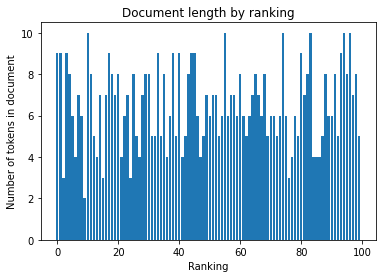

In [53]:
import matplotlib.pyplot as plt

def disp_len(df, scores, k=10):
    sentences = df.iloc[top_k(scores, k)]['headline_text'].str.split(' ')
    sentences = [len(sentence) for sentence in sentences]
    print(f"Average : {np.mean(sentences)} tokens long")
    plt.bar(range(len(sentences)), sentences)
    plt.title('Document length by ranking')
    plt.xlabel("Ranking")
    plt.ylabel("Number of tokens in document")
    plt.show()

disp_len(df, scores, 100)

#### TF-IDF

Let's encode the adjacency matrix with [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

$$TFIDF(\text{word}) = \frac{\text{word count}}{\text{sentence length}} \log_2(\frac{\text{documents count}}{\text{documents with word count}})$$

The ranking now favours very short documents. In those, the term frequency $\frac{\text{word count}}{\text{sentence length}}$ is the highest since sentence length is small. This means links to short articles are the strongest. 

In [55]:
tfidf = TfidfVectorizer(min_df=2, stop_words=stop_words)
adjacency_tfidf = tfidf.fit_transform(df['headline_text'])

print("TF-IDF encoding")
scores_tfidf = bpr.fit_transform(adjacency_tfidf, seeds_col={tfidf.vocabulary_["house"]:1})
disp_results(df, scores_tfidf)

TF-IDF encoding
1: (idx: 660719) house fire
2: (idx: 660718) house crash
3: (idx: 358299) house prices
4: (idx: 781127) bus house
5: (idx: 766494) house fires
6: (idx: 185546) house to house search begins in new orleans
7: (idx: 1121023) a doctor in the house
8: (idx: 823512) house arrest
9: (idx: 760860) police reinforcements conduct house to house
10: (idx: 4141) authorities go house to house to fight dengue


Average : 3.97 tokens long


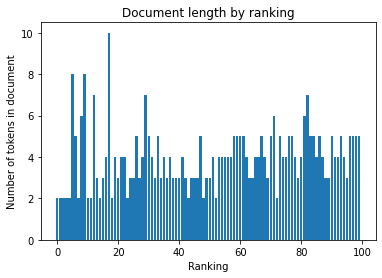

In [54]:
disp_len(df, scores_tfidf, 100)

#### IDF

To mitigate the two previous extremes, we consider only the IDF. We compute it by dividing the TF-IDF values by the TF (term frequency). 

$$IDF(\text{word}) = \log_2(\frac{\text{documents count}}{\text{documents with word count}})$$


In [56]:
freq = TfidfVectorizer(min_df=2, stop_words=stop_words, use_idf=False, vocabulary=tfidf.vocabulary_)
adjacency_freq = freq.fit_transform(df['headline_text'])

adjacency_idf = adjacency_tfidf.copy()
adjacency_idf.data = adjacency_idf.data / adjacency_freq.data

print("IDF encoding")
scores_idf = bpr.fit_transform(adjacency_idf, seeds_col={tfidf.vocabulary_["house"]:1})
disp_results(df, scores_idf)

IDF encoding
1: (idx: 185546) house to house search begins in new orleans
2: (idx: 4141) authorities go house to house to fight dengue
3: (idx: 1148698) white house calls house impeachment probe unconstitutional
4: (idx: 1137501) briggs bad apples house party line up on steps of opera house
5: (idx: 898832) sierra leone to start house to house searches for ebola patients
6: (idx: 1021231) crowded house to reunite for encore opera house gigs
7: (idx: 1078692) brisbane house detective uncovering house histories
8: (idx: 866466) anglican parish to sell house of worship roberts house
9: (idx: 733606) man charged over murder house fire
10: (idx: 439928) man jailed over house fire


Average : 6.47 tokens long


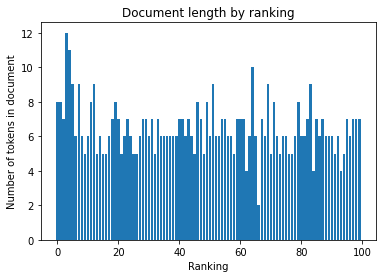

In [57]:
disp_len(df, scores_idf, 100)

Results are more satisfying: 
- we account for rarity of keywords thanks to the IDF
- we don't care about sentence lengths 

However, if we compare the link distributions of the last 3 techniques, we see that we have a long tail for the IDF distribution of link strengths. This means that a few keywords have a very disproportionally large value, and will pull any search results toward them. 

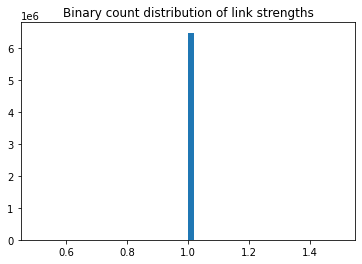

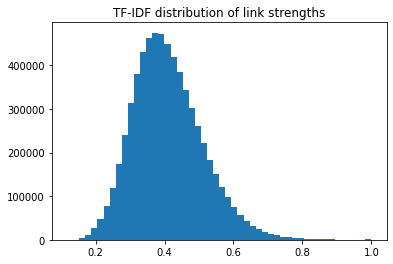

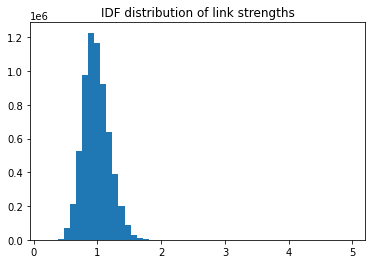

In [73]:
from sknetwork.linalg.normalization import normalize

plt.hist(adjacency.data, bins=50)
plt.title('Binary count distribution of link strengths')
plt.show()

plt.hist(adjacency_tfidf.data, bins=50)
plt.title('TF-IDF distribution of link strengths')
plt.show()

plt.hist(adjacency_idf.data, bins=50)
plt.title('IDF distribution of link strengths')
plt.show()

#### Thresholded IDF

To counter the previous drawback, we threshold the IDF values so the distribution is roughly centered. In our case, it doesn't change search result, but it's safer. 

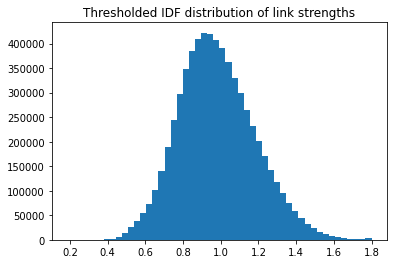

In [77]:
threshold = 1.8

adjacency_idf_thresh = adjacency_idf.copy()
adjacency_idf_thresh.data[adjacency_idf.data > threshold] = threshold

plt.hist(adjacency_idf_thresh.data, bins=50)
plt.title('Thresholded IDF distribution of link strengths')
plt.show()

In [78]:
print("IDF + threshold encoding")
scores_idf_thresh = bpr.fit_transform(adjacency_idf_thresh, seeds_col={tfidf.vocabulary_["house"]:1})
disp_results(df, scores_idf_thresh)

IDF + threshold encoding
1: (idx: 185546) house to house search begins in new orleans
2: (idx: 4141) authorities go house to house to fight dengue
3: (idx: 1148698) white house calls house impeachment probe unconstitutional
4: (idx: 1137501) briggs bad apples house party line up on steps of opera house
5: (idx: 898832) sierra leone to start house to house searches for ebola patients
6: (idx: 1021231) crowded house to reunite for encore opera house gigs
7: (idx: 1078692) brisbane house detective uncovering house histories
8: (idx: 866466) anglican parish to sell house of worship roberts house
9: (idx: 733606) man charged over murder house fire
10: (idx: 439928) man jailed over house fire


Average : 6.47 tokens long


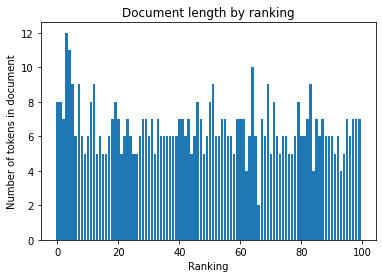

In [79]:
disp_len(df, scores_idf_thresh, 100)

A variant, to account for repetition of keywords, would be to use the following formula :

$$I(\text{word}) = (\text{word count})^{\alpha} \log_2(\frac{\text{documents count}}{\text{documents with word count}})$$

This way, "house house house house" would rank higher than "house house". 


## Using other metadata to link documents

We are building a graph linking document to each other. But links don't have to only be words. Typically, you'd want to use metadata : tags, categories, dates, shared followers or subscribers... 

TODO : link documents by month+year



### References

- [Using Combined Document-Word Graphsfor Wikipedia Search](https://west.uni-koblenz.de/assets/theses/bachelorsthesis_elias_zervudakis_and_felix_engelmann.pdf), bachelor's thesis by Felix Engelmann and Elias Zervudakis. Same idea as this notebook, but they apply it on Wikipedia articles and evaluate search relevancy with user feedback. 

### Special thanks 

Thanks to Thomas Bonald, my teacher at Télécom Paris, for developing the amazing [scikit-network library](https://scikit-network.readthedocs.io/en/latest/index.html) to handle graphs and for opening me to the world of graphs.

Thanks to [Foundamental](https://foundamental.com/), the company where I did an internship, and gave me the opportunity to experiment these ideas freely and giving me feedback on prototypes. 